In [121]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import copy
import numpy as np

In [122]:
XMIN, XMAX = 0.0, 1e5
YMIN, YMAX = -1e6, 1e6

nX = 200 
GLOBAL_X = np.linspace(XMIN, XMAX, nX)
dX = GLOBAL_X[1] - GLOBAL_X[0]

In [123]:
class Dataset():

    def __init__(self, path):
        self.raw_data = pd.read_csv(path)
        self.scaler_X, self.scaler_y = None, None
        self.X, self.y = None, None
        self.drop_scale()

    def drop_scale(self, scaler=None):
        X = ['g', 'bath', 'ts', 'm_lv']
        y = ['t_base', 't_moho']

        if scaler is not None:
            self.scaler_X, self.scaler_y = scaler
        else:
            self.scaler_X, self.scaler_y = MinMaxScaler(), MinMaxScaler()
            
            self.scaler_X.fit(self.raw_data[X])
            self.scaler_y.fit(self.raw_data[y])
            
            self.scaler_X.set_output(transform="pandas")
            self.scaler_y.set_output(transform="pandas")
        
        self.X, self.y = self.scaler_X.transform(self.raw_data[X]), self.scaler_y.transform(self.raw_data[y])

    
    def get_data(self, File=None):
        if File is None:
            File = np.random.choice(self.raw_data.File.unique())
        X = ['g', 'bath', 'ts', 'm_lv']
        
        data = self.raw_data[self.raw_data.File == File].sort_values(by='x')
        layers = data[['sea_zero_lv', 'bath', 'ts', 't_base', 't_moho', 'm_lv']].to_numpy().T
        y_real = data[['t_base', 't_moho']].to_numpy().T
        g = data['g']
        prisms = self.make_prisms(layers)
        # X_features = self.scaler_X.transform(data[X])
        
        return data[X], y_real, g, prisms, File
        
    #Todos os prismas
    def make_prisms(self, layers):
        def make_prism(x, y, z, z_previous, dx):
            n = len(x)
            prism = []
            for i, (x_i, z_i, z_p) in enumerate(zip(x, z, z_previous)):
                if i==0 or i==n-1:
                    ddx = dx*n*0.01  #Correção do efeito de borda
                else:
                    ddx = dx
                prism.append([x_i-ddx/2, x_i+ddx/2, y[0], y[1], z_p, z_i])
            return prism
        
        all_prism = []
        for i, _ in enumerate(layers[1:]):
            all_prism.append(make_prism(GLOBAL_X, (YMIN, YMAX), layers[i+1], layers[i], dX))
        return all_prism


In [134]:
def make_prediction(model, X, scaler_y, scaler_X = None):
    if scaler_X is not None:
        scaled_X = scaler_X.transform(X)
    else:
        scaled_X = X

    return scaler_y.inverse_transform(model.predict(scaled_X)).T

def view_prism(prisms, gsyn, title=None, ax=None):
    title = f"Cenário - {title.split('_')[1]}"
    if ax is None:
        fig, ax = plt.subplots(nrows=2)
    else:
        fig = ax[0].get_figure()
        
    colors = ['b', 'yellow', 'g', 'black', 'red']
    for i, prism in enumerate(prisms):
        for p in prism:
            ax[1].plot([p[0], p[1]], [p[4], p[5]], c=colors[i], alpha=0.3)
    ax[1].invert_yaxis()
    ax[0].set(xlim=(0,100000), title=title, ylabel='Dist. Gravimétrico')
    ax[1].set(xlim=(0,100000), xlabel='X (km)', ylabel='Z (km)')
    ax[0].yaxis.tick_right()
    ax[1].yaxis.tick_right()
    _ = ax[0].plot(GLOBAL_X, gsyn)
    plt.tight_layout()
    return fig, ax

def metrics(real, predicted):
    mae = np.mean(np.abs((real) - (predicted)))
    rmse = np.sqrt(np.mean((np.array(real) - np.array(predicted))**2))
    mse = np.mean(((real) - (predicted))**2)
    return mae, rmse, mse

def plot_result(pred, prisms, g, file=None):
    fig, ax = plt.subplots(nrows=2)
    ax[1].plot(GLOBAL_X, pred[0,:], linewidth=2)
    ax[1].plot(GLOBAL_X, pred[1,:], linewidth=2)
    fig, ax = view_prism(prisms, g, file, ax=ax)
    return fig

## Read and Scale Data

In [135]:
train, test = Dataset("data/series/train/merged_data.csv"), Dataset("data/series/test/merged_data.csv")
test.drop_scale(scaler= (train.scaler_X, train.scaler_y))

## Linear Model - on absolute depths

In [136]:
model = LinearRegression()
_ = model.fit(train.X, train.y)

y_pred = make_prediction(model, test.X, train.scaler_y)
y_real = train.scaler_y.inverse_transform(test.y.to_numpy()).T

base = metrics(y_real[0], y_pred[0])
moho = metrics(y_real[1], y_pred[1])
print(f"Superfície\Métrica     MAE     |    RMSE     |    MSE")
print(f"Embasamento:         {base[0]:^4.1f}    |  {base[1]:^8.1f}   |  {base[2]:^8.1f}")
print(f"Moho:                {moho[0]:^4.1f}    |  {moho[1]:^8.1f}   |  {moho[2]:^8.1f}")

Superfície\Métrica     MAE     |    RMSE     |    MSE
Embasamento:         3111.6    |   3768.6    |  14202449.6
Moho:                2606.8    |   3324.3    |  11051117.6


## Linear Model - on thickness

In [137]:
model = LinearRegression()
_ = model.fit(train.X, train.y)

y_pred = make_prediction(model, test.X, train.scaler_y)
y_real = train.scaler_y.inverse_transform(test.y.to_numpy()).T

base = metrics(y_real[0], y_pred[0])
moho = metrics(y_real[1], y_pred[1])
print(f"Superfície\Métrica     MAE     |    RMSE     |    MSE")
print(f"Embasamento:         {base[0]:^4.1f}    |  {base[1]:^8.1f}   |  {base[2]:^8.1f}")
print(f"Moho:                {moho[0]:^4.1f}    |  {moho[1]:^8.1f}   |  {moho[2]:^8.1f}")

Superfície\Métrica     MAE     |    RMSE     |    MSE
Embasamento:         3111.6    |   3768.6    |  14202449.6
Moho:                2606.8    |   3324.3    |  11051117.6


## View results

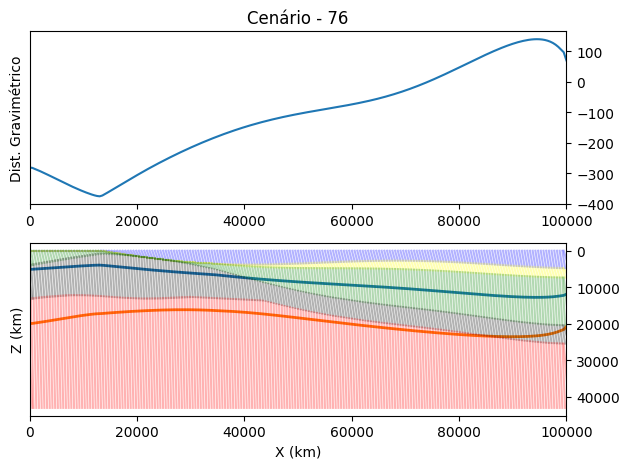

In [138]:
X, y_real, g, prisms, file = train.get_data()
y_pred = make_prediction(model, X, train.scaler_y, train.scaler_X)
fig = plot_result(y_pred, prisms, g, file)